# Linear Regression from scratch -- tensor and auto differentiation

In [1]:
import sys
sys.executable

'D:\\anaconda3\\envs\\d2l\\python.exe'

In [2]:
from d2l import torch as d2l
import torch
import random

In [3]:
# Synthetic dataset with size 1000
# y = 2*x1 + (-3.4)*x2 + 4.2 + noise, noise ~ Normal(mean = 0, sd = 0.01)
def synthetic_dat(w, b, num_examples):
    # design matrix
    X = torch.normal(0, 1, size = (num_examples, len(w)))
    # noise
    noise = torch.normal(0, 0.01, size = (num_examples, 1))
    # y label
    y = torch.matmul(X, w) + b
    return X, y.reshape((-1, 1))

In [4]:
true_w  = torch.tensor([2, -3.4])
true_b = 4.2
num_examples = 1000
features, labels = synthetic_dat(true_w, true_b, num_examples)

In [6]:
print("feature[0]:", features[0,:], "\nlabels[0]:", labels[0,:])

feature[0]: tensor([-2.4826,  0.0797]) 
labels[0]: tensor([-1.0364])


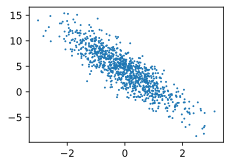

In [7]:
d2l.set_figsize()
d2l.plt.scatter(d2l.numpy(features[:,1]), d2l.numpy(labels[:,0]), 1)

In [8]:
# A generator to yield a minibatch from features and labels
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices, :], labels[batch_indices, :]

In [9]:
# display the first batch
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, "\n", y)
    break

tensor([[-0.9662,  0.1485],
        [-1.4571,  1.0354],
        [ 1.2742, -1.5435],
        [-1.8889, -0.0547],
        [-0.0797, -1.0048],
        [ 0.6927,  2.6279],
        [ 0.0545,  0.4628],
        [ 1.0714, -1.0402],
        [ 1.3841,  1.2179],
        [-1.9160,  0.4113]]) 
 tensor([[ 1.7627],
        [-2.2344],
        [11.9963],
        [ 0.6084],
        [ 7.4568],
        [-3.3493],
        [ 2.7355],
        [ 9.8796],
        [ 2.8274],
        [-1.0306]])


Next step would be initializing parameters, and updating them, which their gradients are required.

## Initialize parameters

In [10]:
# Initialize by normal distribution
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[ 0.0155],
         [-0.0145]], requires_grad=True),
 tensor([0.], requires_grad=True))

## Design the model: input, parameters -> output

In [11]:
def linreg(X, w, b): # how y_hat is compuated. Not just for a single data point
    """The linear regression model"""
    # The matmul() function will take care w no matter it's horizontal or vertical
    # tensor + scalar: broadcasting
    return torch.matmul(X, w) + b

## Define the loss function

In [12]:
# Here we use squared loss
def squared_loss(y_hat, y): 
    ## in linear regression, y and y_hat are scalars.
    ## however, in other model, they might be tensors.
    ## So the loss function's return value may be tensors as well.

    # The result returned by the following function will also have the same shape as y_hat.
    # This means the loss is not aggregated on sample yet.
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2 

## Defining the Optimization Algorithm

In [13]:
def sgd(params, lr, batch_size): #! one step update
    """Stochastic gradient descent."""
    for param in params: # udpate each param
        param.data.sub_(lr*param.grad/batch_size) # .sub_() is in-place method(param.data is updated)
        param.grad.data.zero_() # reset the data of grad to zeor, not the grad to zero.

## Training loop
In each iteration, we will grab a minibatch of training examples, and pass them through our model to obtain a set of predictions. After calculating the loss, we initiate the backwards pass through the network, storing the gradients with respect to each parameter. Finally, we will call the optimization algorithm sgd to update the model parameters.

In [14]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels): # get one minibatch
        l = loss(net(X, w, b), y) # not aggregated yet
        l.sum().backward() # aggregate the loss of the batch, and compute the gradient on l with respect to [w, b]
        sgd([w, b], lr, batch_size)
    with torch.no_grad(): # without this sentence, train_l, created by w, b, will also have grad=True, which will consume memory
        train_l = loss(net(features, w, b), labels)
        print(f"echo {epoch + 1}: train set loss: {float(train_l.mean()):f}")

echo 1: train set loss: 0.032933
echo 2: train set loss: 0.000072
echo 3: train set loss: 0.000000


In [16]:
with torch.no_grad():
    print(f"estimate error for w: {true_w - w.reshape(true_w.shape)}")
    print(f"estimate error for b: {true_b - b}")

estimate error for w: tensor([-8.6546e-05, -4.1389e-04])
estimate error for b: tensor([0.0004])
